In [39]:
try:
    import fastkaggle
except:
    !pip install -U fastkaggle

from fastkaggle import *
api = import_kaggle()

In [2]:
comp = "classification-of-plants-of-southeast-asia"
path = setup_comp(comp)
path

Path('classification-of-plants-of-southeast-asia')

In [3]:
from fastai.vision.all import *
path.ls()

(#3) [Path('classification-of-plants-of-southeast-asia/bali-26_train'),Path('classification-of-plants-of-southeast-asia/bali-26_test'),Path('classification-of-plants-of-southeast-asia/sample_submission.csv')]

In [4]:
trn_path = path/"bali-26_train"
files_all = get_image_files(trn_path)
len(files_all), files_all[0]

(41607,
 Path('classification-of-plants-of-southeast-asia/bali-26_train/bali-26_train/frangipani/12638.jpg'))

In [5]:
from collections import defaultdict

files_by_type = defaultdict(list)
for f in files_all:
    files_by_type[f.parent.name].append(f)

sorted(((x[0], len(x[1])) for x in files_by_type.items()), key=lambda x:x[1])

[('lychee', 1116),
 ('snakefruit', 1167),
 ('suweg', 1191),
 ('sawo', 1222),
 ('cinnamon', 1224),
 ('nilam', 1242),
 ('sugarpalm', 1256),
 ('zodia', 1336),
 ('coffeearabica', 1341),
 ('mango', 1343),
 ('passiflora', 1355),
 ('whitepepper', 1409),
 ('frangipani', 1567),
 ('taro', 1588),
 ('mangosteen', 1624),
 ('papaya', 1645),
 ('cacao', 1682),
 ('starfruit', 1705),
 ('banana', 1716),
 ('waterguava', 1849),
 ('bamboo', 1925),
 ('guava', 1931),
 ('vanilla', 1957),
 ('dragonfruit', 2109),
 ('durian', 2437),
 ('jackfruit', 2670)]

(1080, 1920)


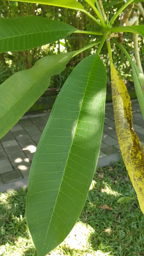

In [6]:
img = PILImage.create(files_all[0])
print(img.size)
img.to_thumb(256)

In [7]:
from PIL import Image

sizes = defaultdict(int)
aspects = defaultdict(int)

for f in files_all:
    i = Image.open(f)
    sizes[i.size] += 1
    aspects[i.aspect] += 1

print(sorted(sizes.items(), key=lambda x:x[1]))
print(sorted(aspects.items(), key=lambda x:x[1]))

[((720, 1280), 403), ((1080, 1920), 14004), ((1920, 1080), 27200)]
[(0.5625, 14407), (1.7777777777777777, 27200)]


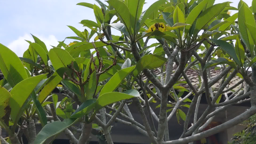

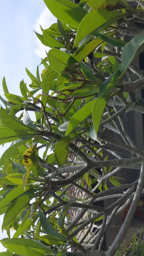

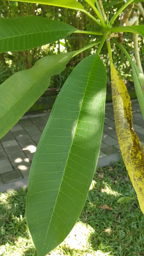

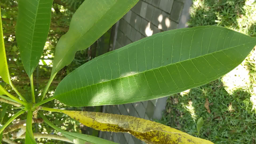

In [8]:
img = next(PILImage.create(i) for i in files_all if Image.open(i).aspect == 1920/1080)
display(img.to_thumb(256))
display(img.transpose(Image.Transpose.TRANSPOSE).to_thumb(256))

img = next(PILImage.create(i) for i in files_all if Image.open(i).aspect == 1080/1920)
display(img.to_thumb(256))
display(img.transpose(Image.Transpose.TRANSPOSE).to_thumb(256))

In [9]:
new_sz = (640, 360)
dest_path = Path("preproc")
def img_preproc(f):
    save_path = dest_path/f
    if save_path.exists() and Image.open(save_path).size == new_sz:
        return

    i = Image.open(f)
    if i.aspect != 1920/1080:
        i = i.transpose(Image.Transpose.TRANSPOSE)

    if i.size != new_sz:
        i = i.resize(new_sz)
    
        save_path.parent.mkdir(exist_ok=True, parents=True)
        i.save(save_path)

from fastcore.parallel import *
parallel(img_preproc, files_all, chunksize=64);

files_all = get_image_files(dest_path/trn_path)

In [16]:
files_by_type = defaultdict(list)
for f in files_all:
    files_by_type[f.parent.name].append(f)

files_subset_pct = 0.05
files_subset = []
val_idxs = []
for cat in files_by_type:
    rel = files_by_type[cat]
    n = len(rel)
    idxs = np.random.choice(n, int(files_subset_pct*n))
    files_subset.extend([rel[i] for i in idxs])
    val_idxs.extend([len(files_subset) - 1 - i for i in range(int(0.2*len(idxs)))])

In [17]:
dls = DataBlock(blocks=(ImageBlock, CategoryBlock),
                get_y=parent_label,
                splitter=IndexSplitter(val_idxs),
                batch_tfms=aug_transforms(size=(180, 320), min_scale=0.75)
).dataloaders(files_subset)

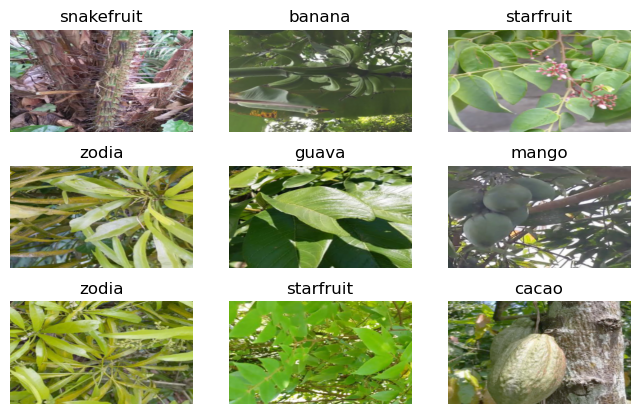

In [18]:
dls.show_batch(figsize=(8, 5))

In [19]:
import timm

learn = vision_learner(dls, "resnet26d", metrics=error_rate, path=".").to_fp16()

SuggestedLRs(valley=0.0012022644514217973, slide=0.0014454397605732083)

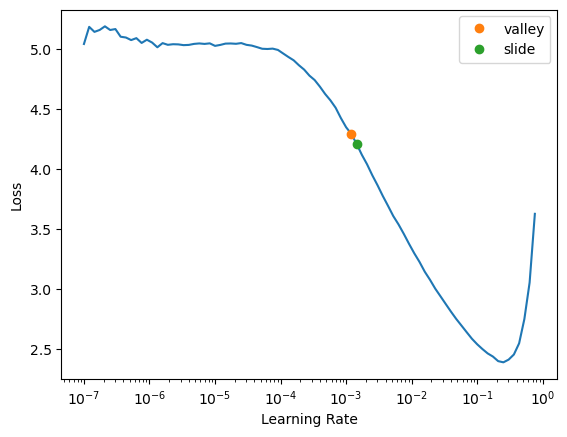

In [14]:
learn.lr_find(suggest_funcs=(valley, slide))

In [42]:
learn.fine_tune(5, 0.01)

epoch,train_loss,valid_loss,error_rate,time
0,0.194926,0.526713,0.143210,00:09


epoch,train_loss,valid_loss,error_rate,time
0,0.211372,0.198550,0.066667,00:09
1,0.167820,0.188385,0.056790,00:09
2,0.142785,0.224449,0.059259,00:09
3,0.113355,0.190598,0.046914,00:09
4,0.089139,0.188807,0.041975,00:09


In [43]:
!head {path}/"sample_submission.csv"

id, category
71.jpg,sugarpalm
11.jpg,cacao
17.jpg,frangipani
4.jpg,waterguava
75.jpg,taro
117.jpg,cacao
177.jpg,frangipani
123.jpg,waterguava
1179.jpg,taro


In [44]:
test_path = path/"bali-26_test"
parallel(img_preproc, get_image_files(test_path), chunksize=64);

In [45]:
files_test = get_image_files(dest_path/test_path)
tst_dl = dls.test_dl(files_test)

In [46]:
probs,_,idxs = learn.get_preds(dl=tst_dl, with_decoded=True)

In [47]:
labels = dls.vocab[idxs]

In [48]:
df = pd.DataFrame({"id": [x.name for x in files_test], "category": labels})
df.head()

,id,category
0,1567.jpg,guava
1,4184.jpg,coffeearabica
2,3558.jpg,guava
3,1809.jpg,mangosteen
4,3579.jpg,dragonfruit


In [49]:
file_subm = f"subm_{comp}.csv"
df.to_csv(file_subm, index=False)
!head {file_subm}

id,category
1567.jpg,guava
4184.jpg,coffeearabica
3558.jpg,guava
1809.jpg,mangosteen
3579.jpg,dragonfruit
253.jpg,durian
3931.jpg,starfruit
706.jpg,sugarpalm
2211.jpg,starfruit


In [50]:
api.competition_submit_cli(file_subm, "5ep rn26d 320x180", comp)

100%|██████████| 78.1k/78.1k [00:00<00:00, 98.2kB/s]


fileName                                             date                 description            status    publicScore  privateScore  
---------------------------------------------------  -------------------  ---------------------  --------  -----------  ------------  
subm_classification-of-plants-of-southeast-asia.csv  2023-06-28 15:11:19  5ep rn26d 320x180      pending                              
subm_classification-of-plants-of-southeast-asia.csv  2023-06-28 15:07:55  initial rn26d 320x180  complete  0.92733      0.93281       
subm_classification-of-plants-of-southeast-asia.csv  2023-06-28 15:07:33  initial rn26d 320x180  complete  0.92733      0.93281       


In [51]:
api.competition_submissions_cli(comp)


fileName                                             date                 description            status    publicScore  privateScore  
---------------------------------------------------  -------------------  ---------------------  --------  -----------  ------------  
subm_classification-of-plants-of-southeast-asia.csv  2023-06-28 15:11:19  5ep rn26d 320x180      complete  0.94723      0.95444       
subm_classification-of-plants-of-southeast-asia.csv  2023-06-28 15:07:55  initial rn26d 320x180  complete  0.92733      0.93281       
subm_classification-of-plants-of-southeast-asia.csv  2023-06-28 15:07:33  initial rn26d 320x180  complete  0.92733      0.93281       
